# Rasgos no basados en modelos

In [1]:
from copy import deepcopy
from itertools import chain
import math
import os

import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from config import DATA_PATH, VISUALIZATIONS_PATH
from utilities import plot_stats, save_dataframe

In [2]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "stats")
os.makedirs(FOLDER, exist_ok=True)

In [3]:
data_path = os.path.join(DATA_PATH, "session_speech.csv")

In [4]:
data = pd.read_csv(data_path, converters={"speech_lemma_pos":eval})
data.columns

Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
       'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
       'speech_pos', 'speech_lemma_pos', 'speech_preprocessed_count',
       'speech_preprocessed_count_unique', 'speech_lemmas_count',
       'speech_lemmas_count_unique', 'speech_pos_count',
       'speech_pos_count_unique', 'speech_lemma_pos_count_unique'],
      dtype='object')

In [5]:
data.shape

(201, 19)

In [6]:
data.head(2)

,name,vote,senator,province,party,party_family,speaker,speech,speech_preprocessed,speech_lemmas,speech_pos,speech_lemma_pos,speech_preprocessed_count,speech_preprocessed_count_unique,speech_lemmas_count,speech_lemmas_count_unique,speech_pos_count,speech_pos_count_unique,speech_lemma_pos_count_unique
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...,hacer año tener una sesión histórica cuando de...,VERB NOUN VERB DET NOUN ADJ SCONJ VERB ADP ADJ...,"[(hacer, VERB), (año, NOUN), (tener, VERB), (u...",1723,602,1684,459,1684,10,462
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...,gracia señor presidente hoy ser un día en el q...,NOUN NOUN NOUN ADV VERB DET NOUN ADP DET SCONJ...,"[(gracia, NOUN), (señor, NOUN), (presidente, N...",411,187,405,146,405,10,147


In [7]:
data.vote.value_counts()

vote
positivo      111
negativo       88
abstención      1
ausente         1
Name: count, dtype: int64

In [8]:
data.speech.isna().sum()

0

In [9]:
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 19)

## Diferencia de frecuencias

Diferencia en la frecuencia absoluta de uso de palabras:

$$
y_{kw}^{(P)}-y_{kw}^{(N)}
$$

Donde k refier e al tópico, w a la palabras y P y N a los senadores que han votado positiva y negativamente, de forma respectiva.
Al considerar en este trabajo un único tópico (el aborto y su legalización), simplificamos, en este aparetado y en los siguientes:

$$
y_{w}^{(P)}-y_{w}^{(N)}
$$

El rpblema con esyte enfoque es que se ve supeditado a aquel conjunto de senadores que haya hablado más.

In [10]:
data["speech_lemma_pos"] = (
    data.speech_lemma_pos.apply(lambda x: " ".join(["_".join(item) for item in x]))
)

In [11]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_lemma_pos)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,a_adp,abajo_adv,abandonada_adj,abandonado_adj,abandonar_verb,abandono_noun,abarcar_verb,abdominal_adj,aber_verb,aberración_noun,...,órgano_noun,óvulo_noun,última_adj,últimamente_adv,último_adj,única_adj,únicamente_adv,único_adj,útero_noun,útil_adj
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,679,1,0,0,1,1,2,0,0,1,...,0,1,3,0,10,4,0,6,3,1
positivo,1546,1,1,1,0,0,0,1,1,0,...,5,1,2,1,19,11,1,8,4,0


In [12]:
count_total = frequencies.sum(axis=0).apply(lambda x: math.log(x))
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,867,1546,679
1,abajo_adv,0.693147,0,1,1
2,abandonada_adj,0.000000,1,1,0
3,abandonado_adj,0.000000,1,1,0
4,abandonar_verb,0.000000,-1,0,1


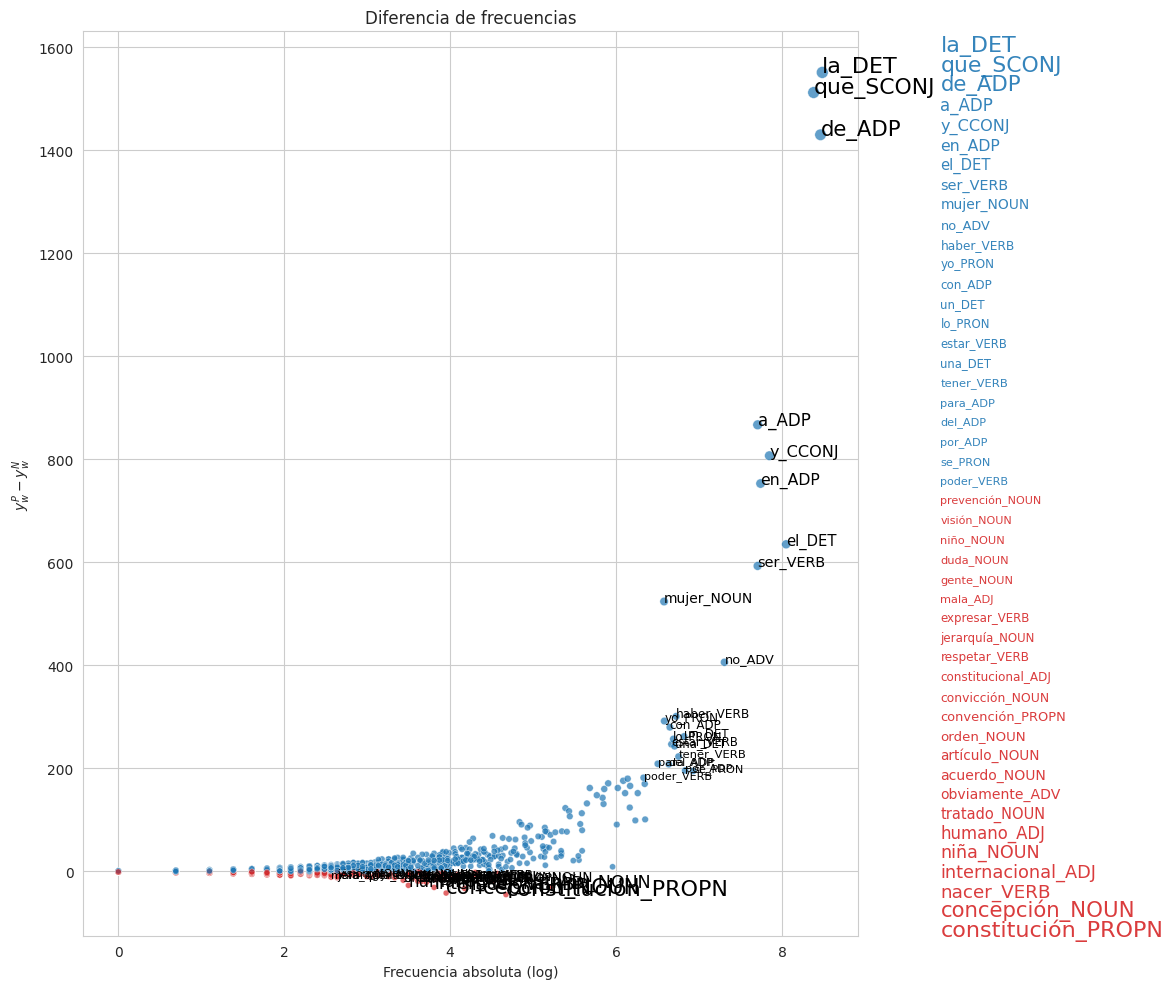

In [13]:
filename = "frecuencias"
save_dataframe(count_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
ax = plot_stats(count_diff, "Diferencia de frecuencias", "$y^{P}_{w}-y^{N}_{w}$", file, nwords=23)

In [14]:
print("POSITIVO")
for key, value in (
    count_diff
    .nlargest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")
print("-----------------------------------------------------------------")
print("NEGATIVO")
for key, value in (
    count_diff
    .nsmallest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")

POSITIVO
`de', `a', `en', `con', `para', `del', `por' (adp)
`no' (adv)
`y' (cconj)
`la', `el', `un', `una', `su' (det)
`mujer' (noun)
`yo', `lo', `se' (pron)
`que' (sconj)
`ser', `haber', `estar', `tener', `poder', `ir' (verb)
-----------------------------------------------------------------
NEGATIVO
`civil', `mala', `constitucional', `humano', `internacional' (adj)
`obviamente' (adv)
`problema', `prevención', `niño', `gente', `duda', `jerarquía', `convicción', `orden', `artículo', `acuerdo', `tratado', `niña', `concepción' (noun)
`código', `convención', `constitución' (propn)
`expresar', `respetar', `nacer' (verb)


## Diferencia de proporciones

Se normalizan los vectores de palabras para reflejar las proporciones en lugar de su ocurrencia. La proporción observada se define como:

$$
f_{w}^{(i)} = y_{w}^{(i)} / n^{(i)}
$$

$$
f_{w}^{(P)}-f_{w}^{(N)}
$$

A diferencia del enfoque anterior, este abordaje evita el sesgo partidario basado en el volumen de los discursos.

La limitación aquí es la carencia de validez semántica, que se puede observar en el énfasis otorgado a las palabras de mayor frecuencia. Las palabras que parecen describir mejor los discursos de ambas posturas no son palabras que denoten posiciones políticas realmente sino palabras de alta frecuencia en el uso.

In [15]:
frequencies.sum(axis=1)

senator_vote
negativo    30468
positivo    56713
dtype: int64

In [16]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,0.004974,0.027260,0.022286
1,abajo_adv,0.693147,-0.000015,0.000018,0.000033
2,abandonada_adj,0.000000,0.000018,0.000018,0.000000
3,abandonado_adj,0.000000,0.000018,0.000018,0.000000
4,abandonar_verb,0.000000,-0.000033,0.000000,0.000033


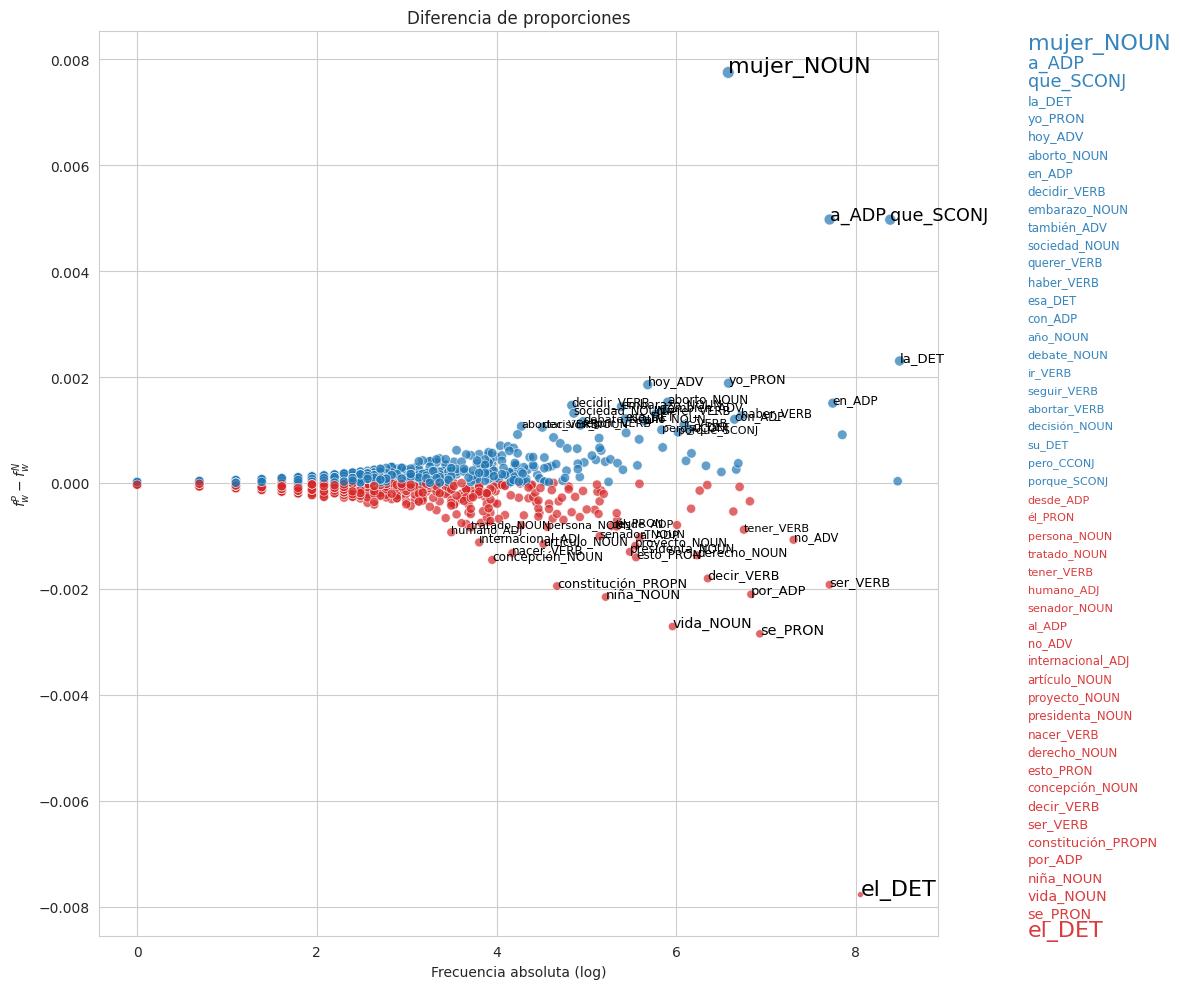

In [17]:
filename = "proporciones"
save_dataframe(proportions_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(proportions_diff, "Diferencia de proporciones", "$f^{P}_{w}-f^{N}_{w}$", file)

In [18]:
print("POSITIVO")
for key, value in (
    proportions_diff
    .nlargest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")
print("-----------------------------------------------------------------")
print("NEGATIVO")
for key, value in (
    proportions_diff
    .nsmallest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")

POSITIVO
`a', `en', `con' (adp)
`hoy', `también' (adv)
`pero' (cconj)
`la', `esa', `su' (det)
`mujer', `aborto', `embarazo', `sociedad', `año', `debate', `decisión' (noun)
`yo' (pron)
`que', `porque' (sconj)
`decidir', `querer', `haber', `ir', `seguir', `abortar' (verb)
-----------------------------------------------------------------
NEGATIVO
`humano', `internacional' (adj)
`desde', `al', `por' (adp)
`no' (adv)
`el' (det)
`persona', `tratado', `senador', `artículo', `proyecto', `presidenta', `derecho', `concepción', `niña', `vida' (noun)
`él', `esto', `se' (pron)
`constitución' (propn)
`tener', `nacer', `decir', `ser' (verb)


## Diferencia de proporciones sin stopwords

El problema del énfasis otorgado a las palabras de alta frecuencia suele intentar superarse aislando las palabras de interés y, para esto, se removuen las _stopwords_.

El problema de eliminar las _stopwords_ es que podemos terminar eliminando palabras que son significativas para el problema en cuestión (ej: "ella" en el tópico aquí abordado).

### Stopwrods de NLTK

In [19]:
nltk.download("stopwords")

from nltk.corpus import stopwords

stw = stopwords.words("spanish")
print(stw[:5])

['de', 'la', 'que', 'el', 'en']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
print(f"Cantidad de columnas (lemas+pos) en el dataset: {len(frequencies.columns)}")
words = [item.split("_")[0] for item in frequencies.columns.to_list()]
stop = len(sorted(set(words).intersection(set(stw))))
print(f"Cantidad de lemas stopwords en el dataset: {stop}")
non_stop = len(sorted(set(words).difference(set(stw))))
print(f"Cantidad de lemas no stopwords en el dataset: {non_stop}")

Cantidad de columnas (lemas+pos) en el dataset: 4901
Cantidad de lemas stopwords en el dataset: 76
Cantidad de lemas no stopwords en el dataset: 4710


In [21]:
columns_wo_stw = list()
for item in sorted(frequencies.columns.to_list()):
    word, _ = item.split("_")
    if word in stw:
        continue
    else:
        columns_wo_stw.append(item)
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4817)

In [22]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,NaN,NaN,NaN
1,abajo_adv,0.693147,-0.000030,0.000035,0.000065
2,abandonada_adj,0.000000,0.000035,0.000035,0.000000
3,abandonado_adj,0.000000,0.000035,0.000035,0.000000
4,abandonar_verb,0.000000,-0.000065,0.000000,0.000065


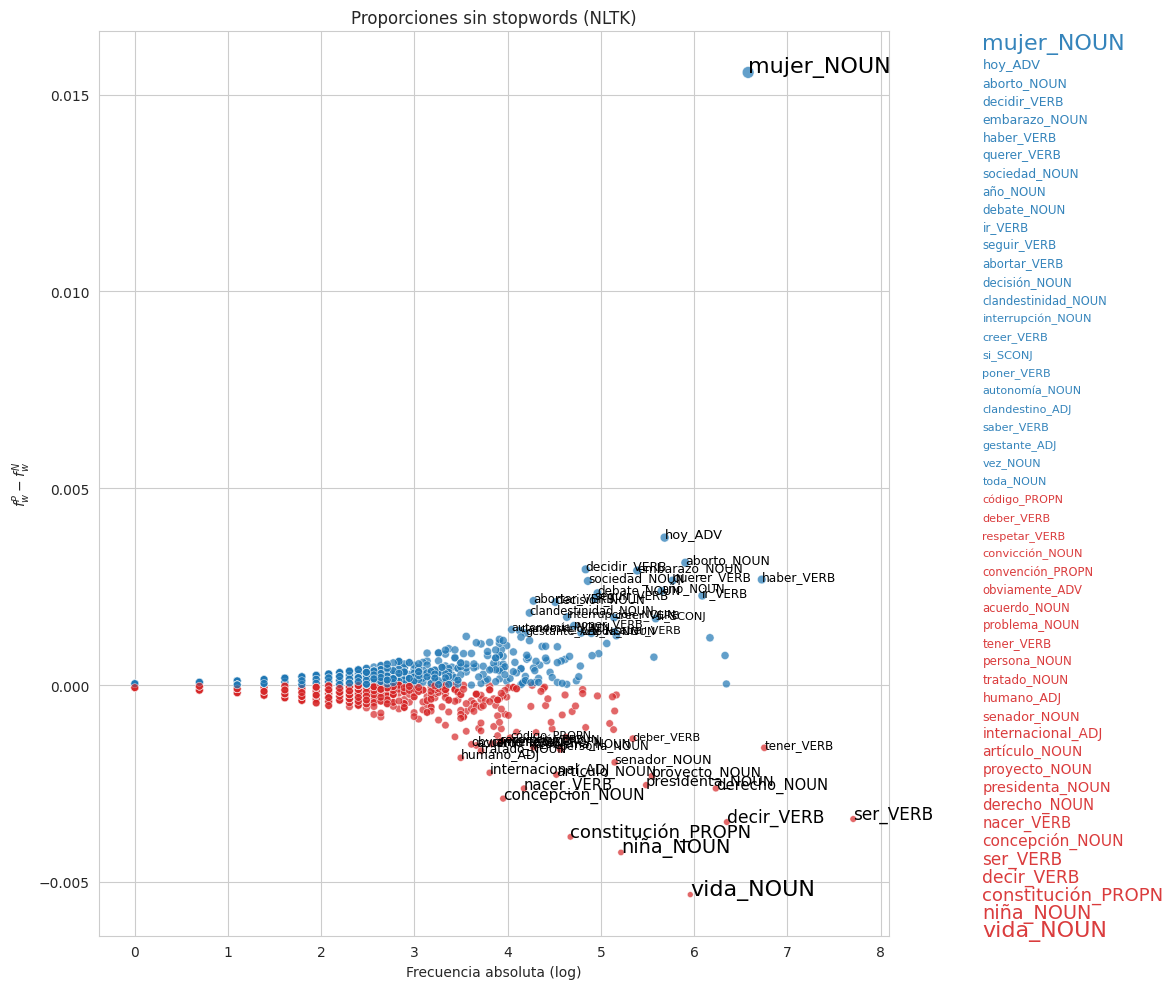

In [23]:
filename = "proporciones_sin_stopwords_nltk"
save_dataframe(proportions_wo_stw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    proportions_wo_stw_diff, "Proporciones sin stopwords (NLTK)", "$f^{P}_{w}-f^{N}_{w}$", file
)

In [24]:
print("POSITIVO")
for key, value in (
    proportions_wo_stw_diff
    .nlargest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")
print("-----------------------------------------------------------------")
print("NEGATIVO")
for key, value in (
    proportions_wo_stw_diff
    .nsmallest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")

POSITIVO
`clandestino', `gestante' (adj)
`hoy' (adv)
`mujer', `aborto', `embarazo', `sociedad', `año', `debate', `decisión', `clandestinidad', `interrupción', `autonomía', `vez', `toda' (noun)
`si' (sconj)
`decidir', `haber', `querer', `ir', `seguir', `abortar', `creer', `poner', `saber' (verb)
-----------------------------------------------------------------
NEGATIVO
`humano', `internacional' (adj)
`obviamente' (adv)
`convicción', `acuerdo', `problema', `persona', `tratado', `senador', `artículo', `proyecto', `presidenta', `derecho', `concepción', `niña', `vida' (noun)
`código', `convención', `constitución' (propn)
`deber', `respetar', `tener', `nacer', `ser', `decir' (verb)


### Stopwords por Ley de Zipf

In [25]:
filename = os.path.join(VISUALIZATIONS_PATH, "zipf_law.csv")
zipf_law = pd.read_csv(filename)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,4909,"['las', 'la']","[1265, 3644]",0.000000,8.498826
1,1,de,ADP,4812,['de'],[4812],0.693147,8.478868
2,2,que,SCONJ,4465,['que'],[4465],1.098612,8.404024
3,3,el,DET,3180,"['el', 'los']","[2008, 1172]",1.386294,8.064636
4,4,y,CCONJ,2584,['y'],[2584],1.609438,7.857094


In [26]:
zipf_law.shape

(4892, 8)

In [27]:
(
    zipf_law.loc[zipf_law.order<100, ["selected_lemma", "selected_pos"]]
    .apply(lambda x: "_".join(x), axis=1)
    .to_list()
)

['la_DET',
 'de_ADP',
 'que_SCONJ',
 'el_DET',
 'y_CCONJ',
 'en_ADP',
 'a_ADP',
 'ser_VERB',
 'no_ADV',
 'se_PRON',
 'por_ADP',
 'un_DET',
 'tener_VERB',
 'haber_VERB',
 'una_DET',
 'lo_PRON',
 'estar_VERB',
 'con_ADP',
 'del_ADP',
 'yo_PRON',
 'mujer_NOUN',
 'para_ADP',
 'decir_VERB',
 'ley_NOUN',
 'poder_VERB',
 'este_DET',
 'derecho_NOUN',
 'hacer_VERB',
 'como_SCONJ',
 'su_DET',
 'esta_DET',
 'ir_VERB',
 'porque_SCONJ',
 'o_CCONJ',
 'vida_NOUN',
 'aborto_NOUN',
 'más_ADV',
 'también_ADV',
 'pero_CCONJ',
 'querer_VERB',
 'hoy_ADV',
 'año_NOUN',
 'mi_DET',
 'al_ADP',
 'si_SCONJ',
 'salud_NOUN',
 'esto_PRON',
 'proyecto_NOUN',
 'presidenta_NOUN',
 'esa_DET',
 'estado_PROPN',
 'todo_NOUN',
 'deber_VERB',
 'embarazo_NOUN',
 'eso_PRON',
 'sobre_ADP',
 'él_PRON',
 'desde_ADP',
 'nuestra_DET',
 'ese_DET',
 'niña_NOUN',
 'todo_ADJ',
 'cuando_SCONJ',
 'argentina_PROPN',
 'dar_VERB',
 'creer_VERB',
 'senador_NOUN',
 'temer_VERB',
 'provincia_NOUN',
 'saber_VERB',
 'nuestro_DET',
 'hablar_VERB

In [28]:
zipf_law[zipf_law.order<100].log_order.max()

4.605170185988092

In [29]:
zipf_law[zipf_law.order<100].log_count.max()

8.498825534058053

In [30]:
(zipf_law["count"] / zipf_law["count"].sum())[zipf_law.order<100]

0     0.055461
1     0.054366
2     0.050445
3     0.035927
4     0.029194
        ...   
95    0.001333
96    0.001288
97    0.001277
98    0.001277
99    0.001220
Name: count, Length: 100, dtype: float64

In [31]:
zipf_stw = zipf_law[zipf_law.order<100].apply(
    lambda x: f"{x.selected_lemma}_{x.selected_pos}".lower(), axis=1
).to_list()
zipf_stw[:5]

['la_det', 'de_adp', 'que_sconj', 'el_det', 'y_cconj']

In [32]:
print(f"Cantidad de columnas (palabras) en el dataset: {len(frequencies.columns)}")
stop = len(sorted(set(frequencies.columns).intersection(set(zipf_stw))))
print(f"Cantidad de palabras stopwords en el dataset: {stop}")
non_stop = len(sorted(set(frequencies.columns).difference(set(zipf_stw))))
print(f"Cantidad de palabras no stopwords en el dataset: {non_stop}")

Cantidad de columnas (palabras) en el dataset: 4901
Cantidad de palabras stopwords en el dataset: 100
Cantidad de palabras no stopwords en el dataset: 4801


In [33]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(zipf_stw)))
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4801)

In [34]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,NaN,NaN,NaN
1,abajo_adv,0.693147,-0.000040,0.000052,0.000092
2,abandonada_adj,0.000000,0.000052,0.000052,0.000000
3,abandonado_adj,0.000000,0.000052,0.000052,0.000000
4,abandonar_verb,0.000000,-0.000092,0.000000,0.000092


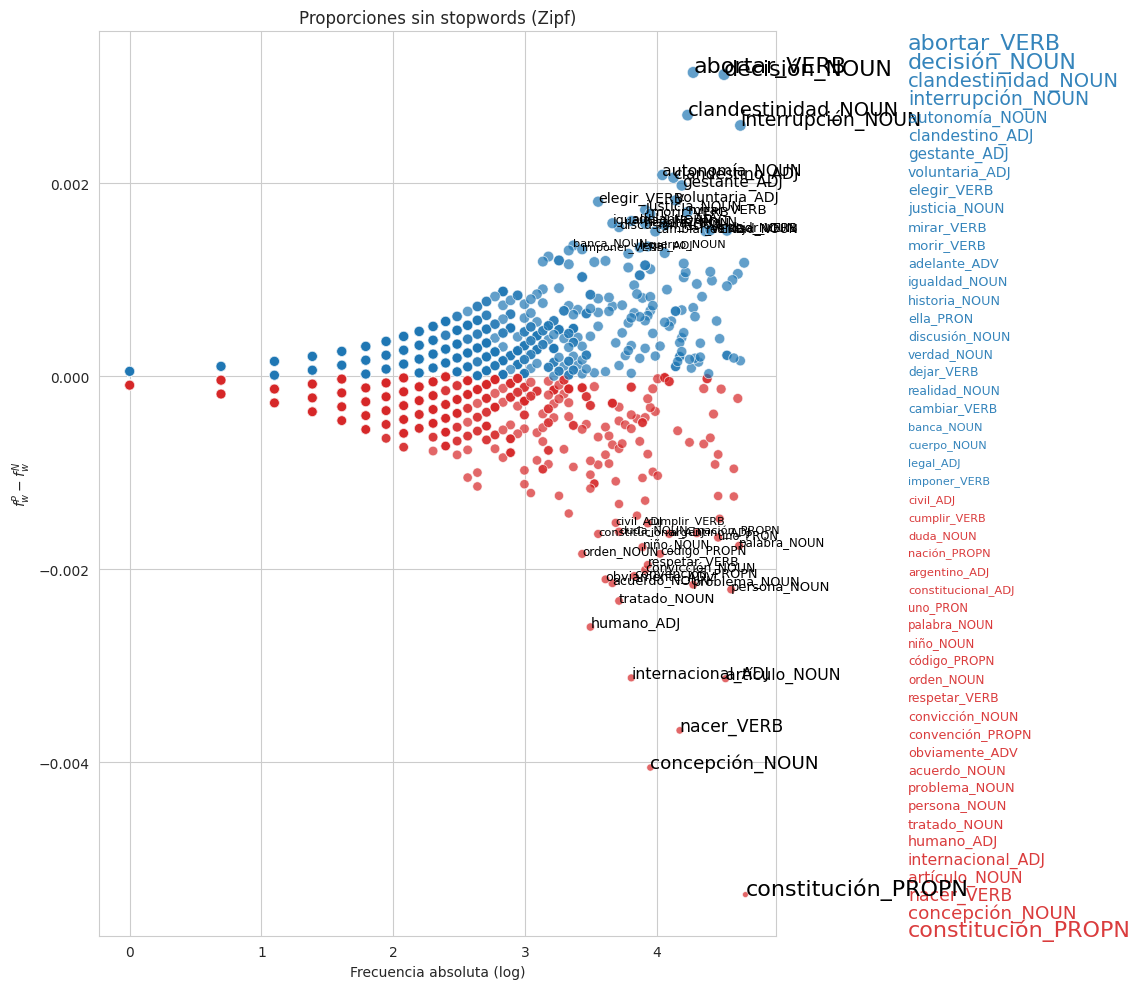

In [35]:
filename = "proporciones_sin_stopwords_zipf"
save_dataframe(proportions_wo_stw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    proportions_wo_stw_diff, "Proporciones sin stopwords (Zipf)", "$f^{P}_{w}-f^{N}_{w}$", file
)

In [36]:
print("POSITIVO")
for key, value in (
    proportions_wo_stw_diff
    .nlargest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")
print("-----------------------------------------------------------------")
print("NEGATIVO")
for key, value in (
    proportions_wo_stw_diff
    .nsmallest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")

POSITIVO
`clandestino', `gestante', `voluntaria', `legal' (adj)
`adelante' (adv)
`decisión', `clandestinidad', `interrupción', `autonomía', `justicia', `igualdad', `historia', `discusión', `verdad', `realidad', `banca', `cuerpo' (noun)
`ella' (pron)
`abortar', `elegir', `mirar', `morir', `dejar', `cambiar', `imponer' (verb)
-----------------------------------------------------------------
NEGATIVO
`civil', `argentino', `constitucional', `humano', `internacional' (adj)
`obviamente' (adv)
`duda', `palabra', `niño', `orden', `convicción', `acuerdo', `problema', `persona', `tratado', `artículo', `concepción' (noun)
`uno' (pron)
`nación', `código', `convención', `constitución' (propn)
`cumplir', `respetar', `nacer' (verb)


## Ratio odds

$$
O_{w}^{i} = \frac{f_{w}^{i}}{(1-f_{w}^{i})}
$$

$$
\theta_{w}^{(P-N)} = \frac{O_{w}^{(P)}}{O_{w}^{(N)}}
$$

In [37]:
odds_pos = proportions.loc["positivo"]/(1-proportions.loc["positivo"])
odds_neg = proportions.loc["negativo"]/(1-proportions.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,1.229465,0.028024,0.022794
1,abajo_adv,0.693147,0.537223,0.000018,0.000033
2,abandonada_adj,0.000000,inf,0.000018,0.000000
3,abandonado_adj,0.000000,inf,0.000018,0.000000
4,abandonar_verb,0.000000,0.000000,0.000000,0.000033


In [38]:
odds_diff["diff"].isin([math.inf]).sum(), odds_diff["diff"].isin([-math.inf]).sum()

(1871, 0)

In [39]:
odds_diff.shape

(4901, 5)

In [40]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg in infs):
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [41]:
# remove infs to avoid ploting inf values
odds_diff_not_inf = odds_diff[~odds_diff["diff"].isin([math.inf, -math.inf])]

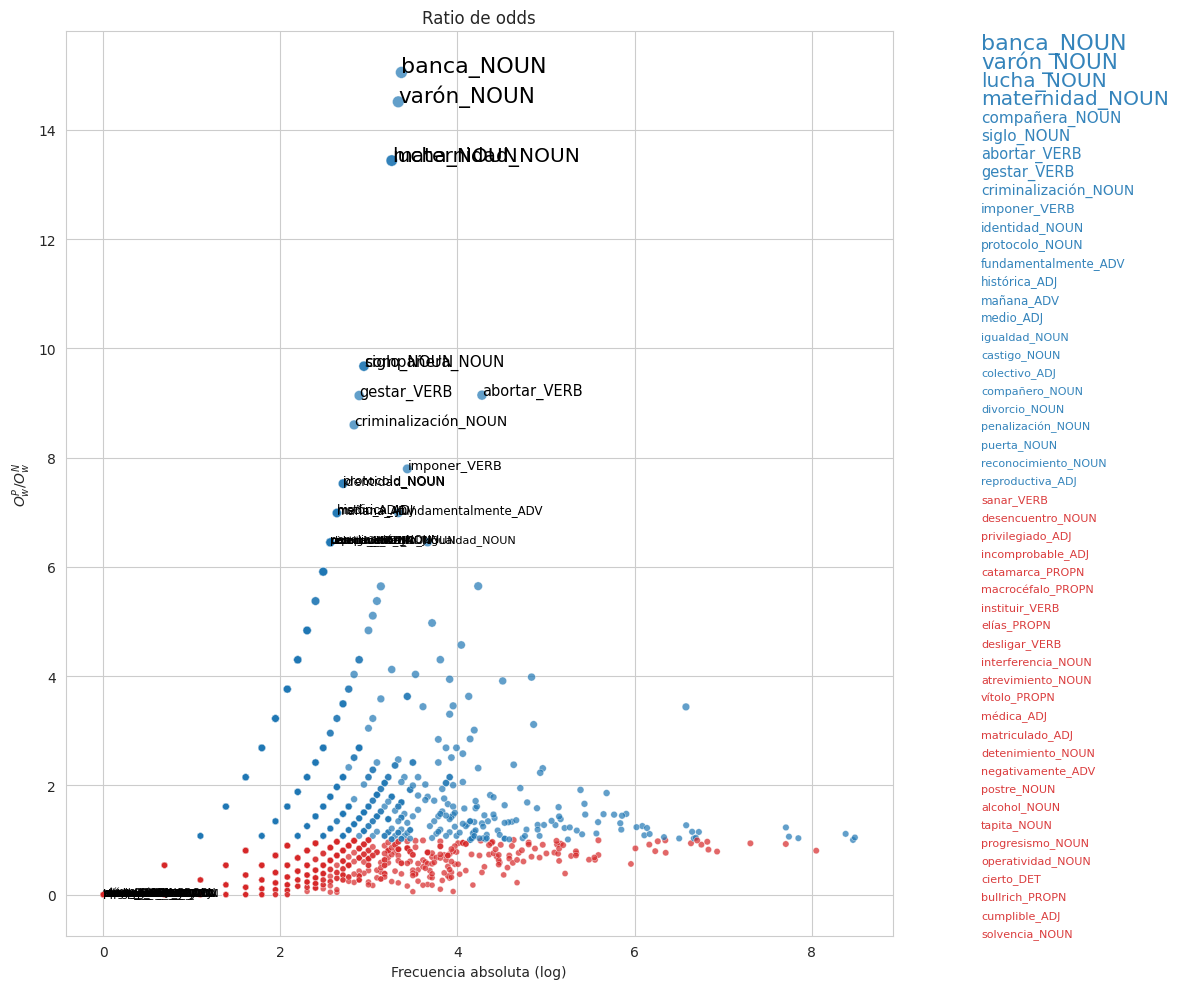

In [42]:
filename = "odds"
save_dataframe(odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(odds_diff_not_inf, "Ratio de odds", "$O^{P}_{w}/O^{N}_{w}$", file, threshold=1)

In [43]:
print("POSITIVO")
for key, value in (
    odds_diff
    .nlargest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")
print("-----------------------------------------------------------------")
print("NEGATIVO")
for key, value in (
    odds_diff
    .nsmallest(25, columns=["diff"])
    .sort_values(by="diff", ascending=False)
    .assign(
        w = lambda x: x.word.apply(lambda z: z.split("_")[0]),
        t = lambda x: x.word.apply(lambda z: z.split("_")[1])
    )
    .groupby("t")["w"].apply(
        lambda x: ", ".join(pd.Series(x).apply(lambda z: f"`{z}'").tolist())
    )
).items():
    print(f"{value} ({key})")

POSITIVO
`abandonada', `abultado', `abstracto', `abandonado', `abortivo', `abortista', `abierto', `abierta', `abdominal', `aceptada' (adj)
`abrumadoramente' (adv)
`absolución', `acento', `accesibilidad', `abuelo', `abuelastro', `abstracción', `abstención', `abolición', `abogada', `abismo' (noun)
`abstener', `absolver', `abrazar', `aber' (verb)
-----------------------------------------------------------------
NEGATIVO
`administrado', `activa', `acertado', `acelerada', `abusiva', `abocado' (adj)
`acertadamente', `abruptamente', `abiertamente' (adv)
`adjetivación', `actuación', `actor', `abandono', `abogado', `aberración' (noun)
`adn', `adam', `adolfo' (propn)
`abandonar', `acordado', `acontecer', `acentuar', `acelerar', `acatar', `abarcar' (verb)


## Ratio de log-odds

El problema de los _odds_ es que, por su asimetría, son muy difíciles de interpretar. Tomar el logaritmo del ratio permite tener una medida simétrica entre ambas posturas de votantes.

$$
\log{\bigg(\frac{O_{w}^{(P)}}{O_{w}^{(N)}}\bigg)}
$$

El problema aquí reside en qué hacer con las palabras que solo son mencionadas por una de las posturas y que, entonces, conducen a _odds_ infinitos.

In [44]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,a_adp,7.707512,0.206579,0.028024,0.022794
1,abajo_adv,0.693147,-0.621342,0.000018,0.000033
2,abandonada_adj,0.000000,inf,0.000018,0.000000
3,abandonado_adj,0.000000,inf,0.000018,0.000000
4,abandonar_verb,0.000000,-inf,0.000000,0.000033


In [45]:
# palabras más representativas de quienes votaron a favor
(
    log_odds_diff
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,elegir_verb,3.555348,inf,0.000618,0.0
1,nosotras_pron,3.178054,inf,0.000423,0.0
2,piba_noun,3.135494,inf,0.000406,0.0
3,afirmativo_adj,2.833213,inf,0.000300,0.0
4,década_noun,2.833213,inf,0.000300,0.0
5,marina_propn,2.833213,inf,0.000300,0.0
6,matrimonio_noun,2.772589,inf,0.000282,0.0
7,definitiva_noun,2.708050,inf,0.000265,0.0
8,violada_adj,2.708050,inf,0.000265,0.0
9,feminista_adj,2.639057,inf,0.000247,0.0


In [46]:
# palabras más representativas de quienes votaron a favor removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,banca_noun,3.367296,2.711339,0.000494,0.000033
1,varón_noun,3.332205,2.674954,0.000476,0.000033
2,lucha_noun,3.258097,2.597957,0.000441,0.000033
3,maternidad_noun,3.258097,2.597957,0.000441,0.000033
4,compañera_noun,2.944439,2.269330,0.000317,0.000033
5,siglo_noun,2.944439,2.269330,0.000317,0.000033
6,abortar_verb,4.276666,2.212955,0.001200,0.000131
7,gestar_verb,2.890372,2.212154,0.000300,0.000033
8,criminalización_noun,2.833213,2.151512,0.000282,0.000033
9,imponer_verb,3.433987,2.053268,0.000512,0.000066


In [47]:
# palabras más representativas de quienes votaron en contra
(
    log_odds_diff
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,smith_propn,2.079442,-inf,0.0,0.000263
1,universal_adj,2.079442,-inf,0.0,0.000263
2,mera_adj,1.945910,-inf,0.0,0.000230
3,rosatti_propn,1.945910,-inf,0.0,0.000230
4,constitucionalista_adj,1.791759,-inf,0.0,0.000197
5,eduardo_propn,1.791759,-inf,0.0,0.000197
6,ende_noun,1.791759,-inf,0.0,0.000197
7,hambre_noun,1.791759,-inf,0.0,0.000197
8,jurar_verb,1.791759,-inf,0.0,0.000197
9,mayoritaria_adj,1.791759,-inf,0.0,0.000197


In [48]:
# palabras más representativas de quienes votaron en contra removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,jerarquía_noun,2.639057,-3.186685,0.000018,0.000427
1,mala_adj,2.564949,-3.106609,0.000018,0.000394
2,humano_adj,3.496508,-2.924844,0.000053,0.000986
3,concepción_noun,3.951244,-2.863492,0.000088,0.001545
4,declaración_noun,2.302585,-2.818829,0.000018,0.000295
5,científico_adj,2.079442,-2.567449,0.000018,0.000230
6,honrar_verb,2.079442,-2.567449,0.000018,0.000230
7,prioridad_noun,2.079442,-2.567449,0.000018,0.000230
8,tercio_noun,2.079442,-2.567449,0.000018,0.000230
9,visión_noun,2.639057,-2.413445,0.000035,0.000394


In [49]:
# remove infs to avoid ploting inf values
log_odds_diff_not_inf = log_odds_diff[~log_odds_diff["diff"].isin([math.inf, -math.inf])]

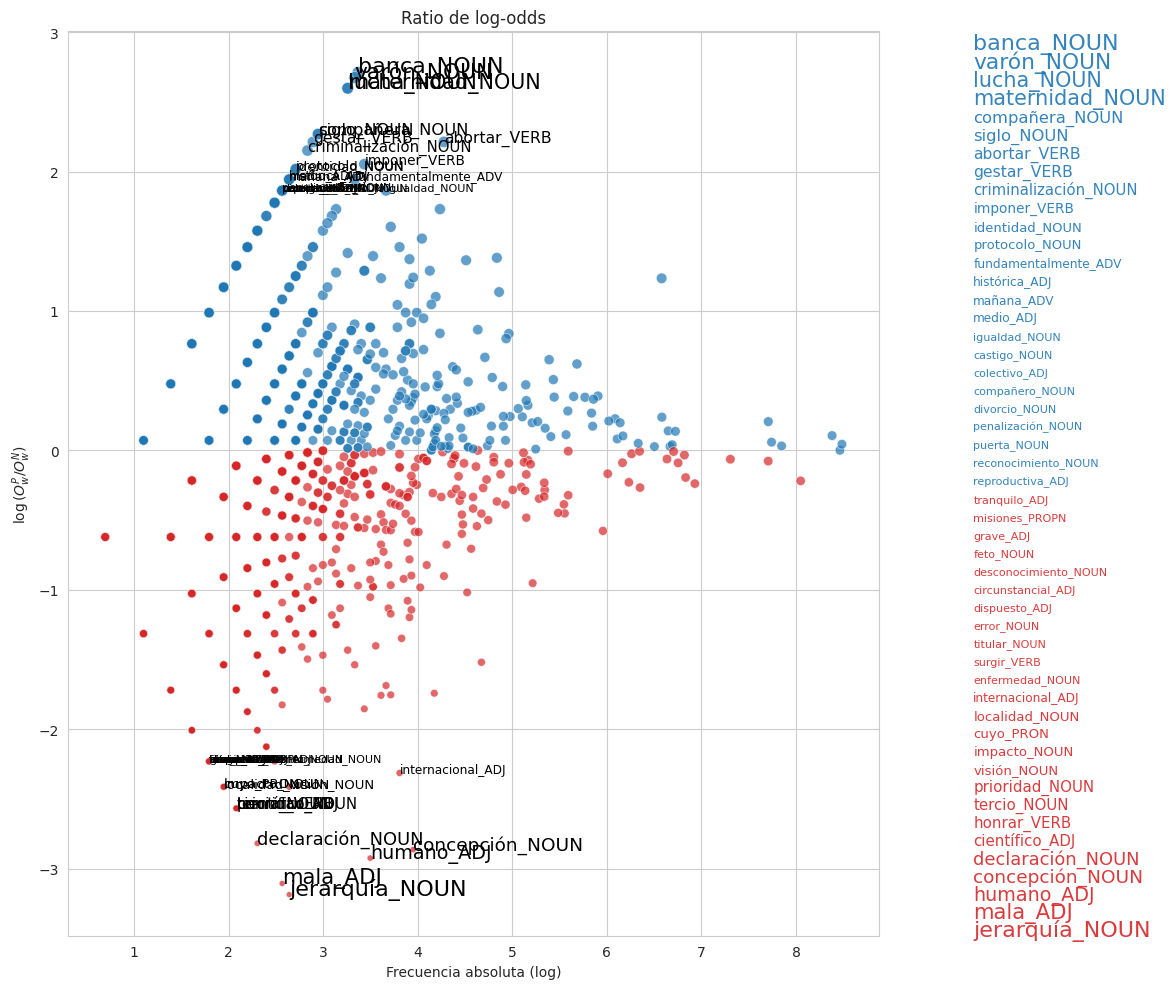

In [50]:
filename = "log_odds"
save_dataframe(log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    log_odds_diff_not_inf, "Ratio de log-odds", "$\log{(O^{P}_{w}/O^{N}_{w})}$", file
)

### Log-odds ratio suvizado

Una opción para sobrellevar el problema de los _odds_ infinitos es agregar suavizado (por ejemplo: 0.5):
$$
\widetilde{f}^{(i)} = f^{(i)} + \varepsilon
$$

En este enfoque, el problema mayor es que las métricas se ven dominadas por los casos de palabras más oscuras o que aparecen menos.

In [51]:
smooth_log_odds_diff = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
smooth_log_odds_diff.head()

,word,total,pos,neg
0,a_adp,7.707512,0.027260,0.022286
1,abajo_adv,0.693147,0.000018,0.000033
2,abandonada_adj,0.000000,0.000018,0.000000
3,abandonado_adj,0.000000,0.000018,0.000000
4,abandonar_verb,0.000000,0.000000,0.000033


In [52]:
# cantidad de palabras con frecuencia 0
(smooth_log_odds_diff[["pos", "neg"]]==0).sum(axis=0)

pos    1123
neg    1871
dtype: int64

In [53]:
smooth_log_odds_diff[["f_pos", "f_neg"]] = smooth_log_odds_diff[["pos", "neg"]].applymap(
    lambda x: x+0.5 if x == 0 else x
)
smooth_log_odds_diff.head()

,word,total,pos,neg,f_pos,f_neg
0,a_adp,7.707512,0.027260,0.022286,0.027260,0.022286
1,abajo_adv,0.693147,0.000018,0.000033,0.000018,0.000033
2,abandonada_adj,0.000000,0.000018,0.000000,0.000018,0.500000
3,abandonado_adj,0.000000,0.000018,0.000000,0.000018,0.500000
4,abandonar_verb,0.000000,0.000000,0.000033,0.500000,0.000033


In [54]:
(smooth_log_odds_diff[["f_pos", "f_neg"]]==0).sum(axis=0)

f_pos    0
f_neg    0
dtype: int64

In [55]:
f_smooth_odds_pos = smooth_log_odds_diff["f_pos"]/(1-smooth_log_odds_diff["f_pos"])
f_smooth_odds_neg = smooth_log_odds_diff["f_neg"]/(1-smooth_log_odds_diff["f_neg"])
f_smooth_odds_difference = f_smooth_odds_pos/f_smooth_odds_neg
f_smooth_log_odds_diff = (
    pd
    .DataFrame({
        "word": smooth_log_odds_diff.word,
        "total": smooth_log_odds_diff.total,
        "diff": np.log(f_smooth_odds_difference),
        "pos": f_smooth_odds_pos,
        "neg": f_smooth_odds_pos
    })
)
f_smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.707512,0.206579,0.028024,0.028024
1,abajo_adv,0.693147,-0.621342,0.000018,0.000018
2,abandonada_adj,0.000000,-10.945741,0.000018,0.000018
3,abandonado_adj,0.000000,-10.945741,0.000018,0.000018
4,abandonar_verb,0.000000,10.324399,1.000000,1.000000


In [56]:
filename = "log_odds_suavizado"
save_dataframe(f_smooth_log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
#plot_stats(
#    f_smooth_log_odds_diff,
#    "Ratio de log-odds suavizado (0.5)",
#    "smooth $\log{(O^{P}_{w}/O^{N}_{w})}$",
#    file
#)

## Ratio de log-odds sin palabras de baja frecuencia

Se define un umbral a partir del cual se considera que una palabra es frecuente y se consideran solo aquellas qcuya frecuencia supera ese umbral.
Esto remueve los rasgos más problemáticos pero no resuelve el problema de fondo.

In [57]:
proportions_diff.total.describe().to_frame()

,total
count,4901.000000
mean,1.060010
std,1.324823
min,0.000000
25%,0.000000
50%,0.693147
75%,1.609438
max,8.486528


In [58]:
(
    pd.melt(
        proportions_diff[["word","total","pos","neg"]],
        id_vars=["word"],
        value_vars=["pos", "neg","total"],
    )
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

,min,q5,median,mean,std,q95,max
variable,,,,,,,
neg,0.0,0.0,0.000033,0.000204,0.001727,0.000492,0.054418
pos,0.0,0.0,0.000018,0.000204,0.001753,0.000476,0.056424
total,0.0,0.0,0.693147,1.060010,1.324823,3.784190,8.486528


In [59]:
proportions_diff.shape

(4901, 5)

In [60]:
high_freq = (
    proportions_diff
    .loc[proportions_diff.total>1, ["word", "total", "pos", "neg"]]
    .reset_index(drop=True)
)
high_freq.shape

(2040, 4)

In [61]:
high_freq_perc = round(high_freq.shape[0]/proportions_diff.shape[0]*100,2)
print(
    f"Tras remover las palabras de baja frecuencia, nos quedamos con el {high_freq_perc}% de los datos"
)

Tras remover las palabras de baja frecuencia, nos quedamos con el 41.62% de los datos


In [62]:
# palabras removidas
proportions_diff[proportions_diff.total<=0.25].word.to_list()

['abandonada_adj',
 'abandonado_adj',
 'abandonar_verb',
 'abandono_noun',
 'abdominal_adj',
 'aber_verb',
 'aberración_noun',
 'abiertamente_adv',
 'abierto_adj',
 'abismo_noun',
 'abocado_adj',
 'abogada_noun',
 'abogado_noun',
 'abolición_noun',
 'abortista_adj',
 'abortivo_adj',
 'abruptamente_adv',
 'absolución_noun',
 'absolver_verb',
 'abstención_noun',
 'abstracción_noun',
 'abstracto_adj',
 'abuelastro_noun',
 'abuelo_noun',
 'abultado_adj',
 'abusiva_adj',
 'accesibilidad_noun',
 'acelerada_adj',
 'acelerar_verb',
 'acento_noun',
 'acentuar_verb',
 'aceptada_adj',
 'acertadamente_adv',
 'acomodar_verb',
 'acompañado_adj',
 'acompañante_noun',
 'acompañasar_verb',
 'aconsejar_verb',
 'acontecer_verb',
 'acordado_verb',
 'activismo_noun',
 'actor_noun',
 'adam_propn',
 'adecuado_adj',
 'adjetivación_noun',
 'adjetivar_adv',
 'adjetivar_verb',
 'adjudicar_verb',
 'administrado_adj',
 'administrativamente_adv',
 'admiración_noun',
 'admirar_verb',
 'admisible_adj',
 'adolfo_propn

In [63]:
(high_freq[["pos", "neg"]] == 0).sum()

pos     80
neg    305
dtype: int64

In [64]:
high_freq_odds_pos = high_freq["pos"]/(1-high_freq["pos"])
high_freq_odds_neg = high_freq["neg"]/(1-high_freq["neg"])
high_freq_odds_difference = high_freq_odds_pos/high_freq_odds_neg
high_freq_log_odds_diff = (
    pd
    .DataFrame({
        "word": high_freq.word,
        "total": high_freq.total,
        "diff": np.log(high_freq_odds_difference),
        "pos": high_freq_odds_pos,
        "neg": high_freq_odds_neg
    })
    .reset_index(drop=True)
)
high_freq_log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,a_adp,7.707512,0.206579,0.028024,0.022794
1,abogado_det,1.791759,-2.230911,0.000018,0.000164
2,abordaje_noun,1.609438,-2.007735,0.000018,0.000131
3,abordar_verb,2.484907,0.988222,0.000176,0.000066
4,abortar_verb,4.276666,2.212955,0.001200,0.000131


In [65]:
# remove infs to avoid ploting inf values
high_freq_log_odds_diff_not_inf = high_freq_log_odds_diff[
    ~high_freq_log_odds_diff["diff"].isin([math.inf, -math.inf])
]

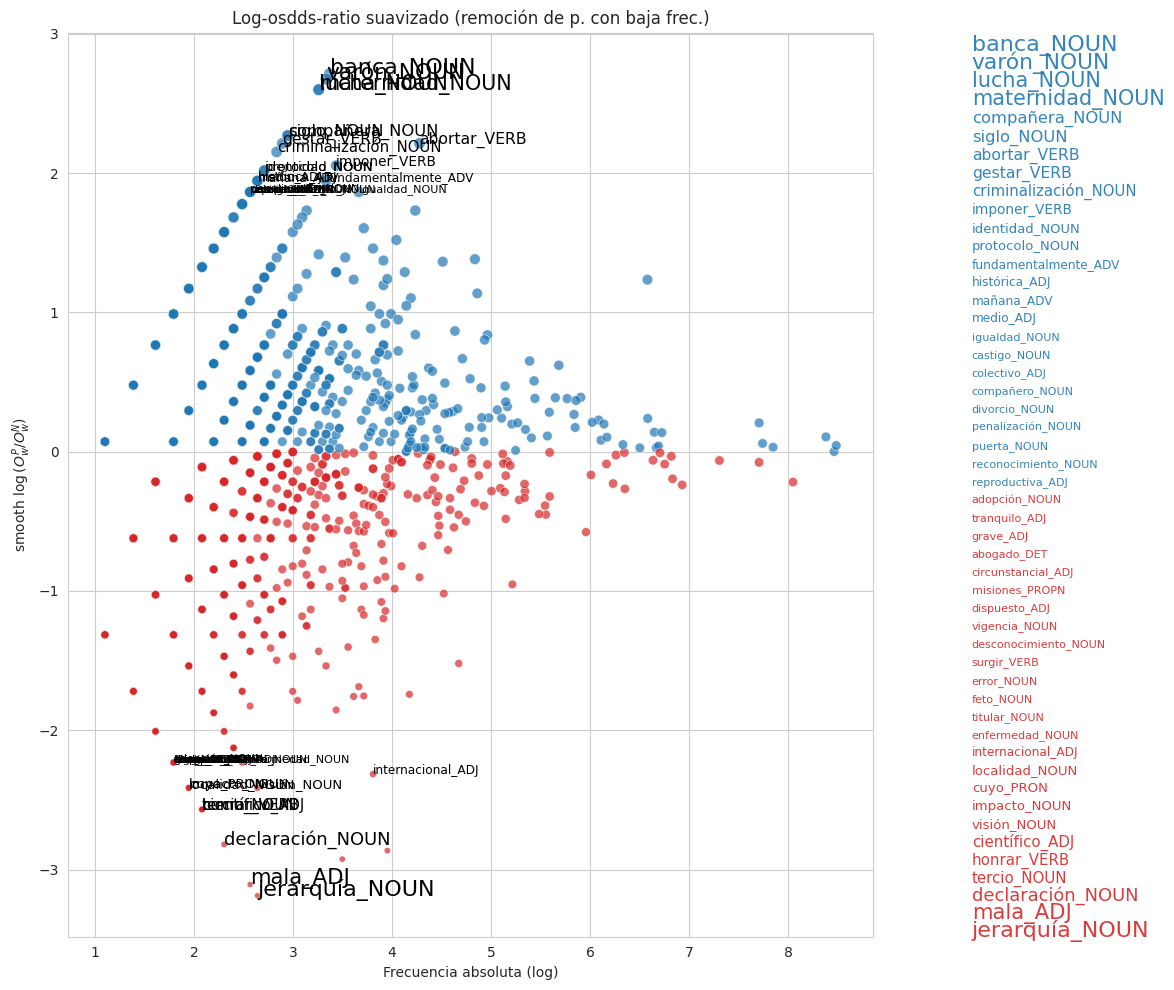

In [66]:
filename = "log_odds_sin_baja_freq"
save_dataframe(high_freq_log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    high_freq_log_odds_diff_not_inf,
    "Log-osdds-ratio suavizado (remoción de p. con baja frec.)",
    "smooth $\log{(O^{P}_{w}/O^{N}_{w})}$",
    file
)

## TF-IDF

### Frecuencia de término natural, frecuencia de documento _logged_, no normalizado

$$
\text{tf.idf}_{w}^{(i)}(ntn) = f_{w}^{(i)}\ln{(1/df_{w})}
$$

$$
\text{tf.idf}_{w}^{(i)}(nnn) = f_{w}^{(i)}/df_{w}
$$

In [67]:
tf_idf = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
tf_idf.rename(columns={"pos":"f_pos", "neg":"f_neg"}, inplace=True)
tf_idf.head()

,word,total,f_pos,f_neg
0,a_adp,7.707512,0.027260,0.022286
1,abajo_adv,0.693147,0.000018,0.000033
2,abandonada_adj,0.000000,0.000018,0.000000
3,abandonado_adj,0.000000,0.000018,0.000000
4,abandonar_verb,0.000000,0.000000,0.000033


In [68]:
tf_idf["df"] = tf_idf.apply(lambda x: 1/2 if (0<x.f_pos and 0<x.f_neg) else 1/1, axis=1)
tf_idf.head()

,word,total,f_pos,f_neg,df
0,a_adp,7.707512,0.027260,0.022286,0.5
1,abajo_adv,0.693147,0.000018,0.000033,0.5
2,abandonada_adj,0.000000,0.000018,0.000000,1.0
3,abandonado_adj,0.000000,0.000018,0.000000,1.0
4,abandonar_verb,0.000000,0.000000,0.000033,1.0


In [69]:
tfidf_diff = (
    pd
    .DataFrame({
        "word": tf_idf["word"],
        "pos": tf_idf.apply(lambda x: x.f_pos*math.log(x.df), axis=1),
        "neg": tf_idf.apply(lambda x: x.f_neg*math.log(x.df), axis=1)
    })
    .assign(diff=lambda x: x.pos - x.neg)
    .merge(count_diff[["word", "total"]], on="word")
)
tfidf_diff.head()

,word,pos,neg,diff,total
0,a_adp,-0.018895,-0.015447,-0.003448,7.707512
1,abajo_adv,-0.000012,-0.000023,0.000011,0.693147
2,abandonada_adj,0.000000,0.000000,0.000000,0.000000
3,abandonado_adj,0.000000,0.000000,0.000000,0.000000
4,abandonar_verb,0.000000,0.000000,0.000000,0.000000


In [70]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: -0.99


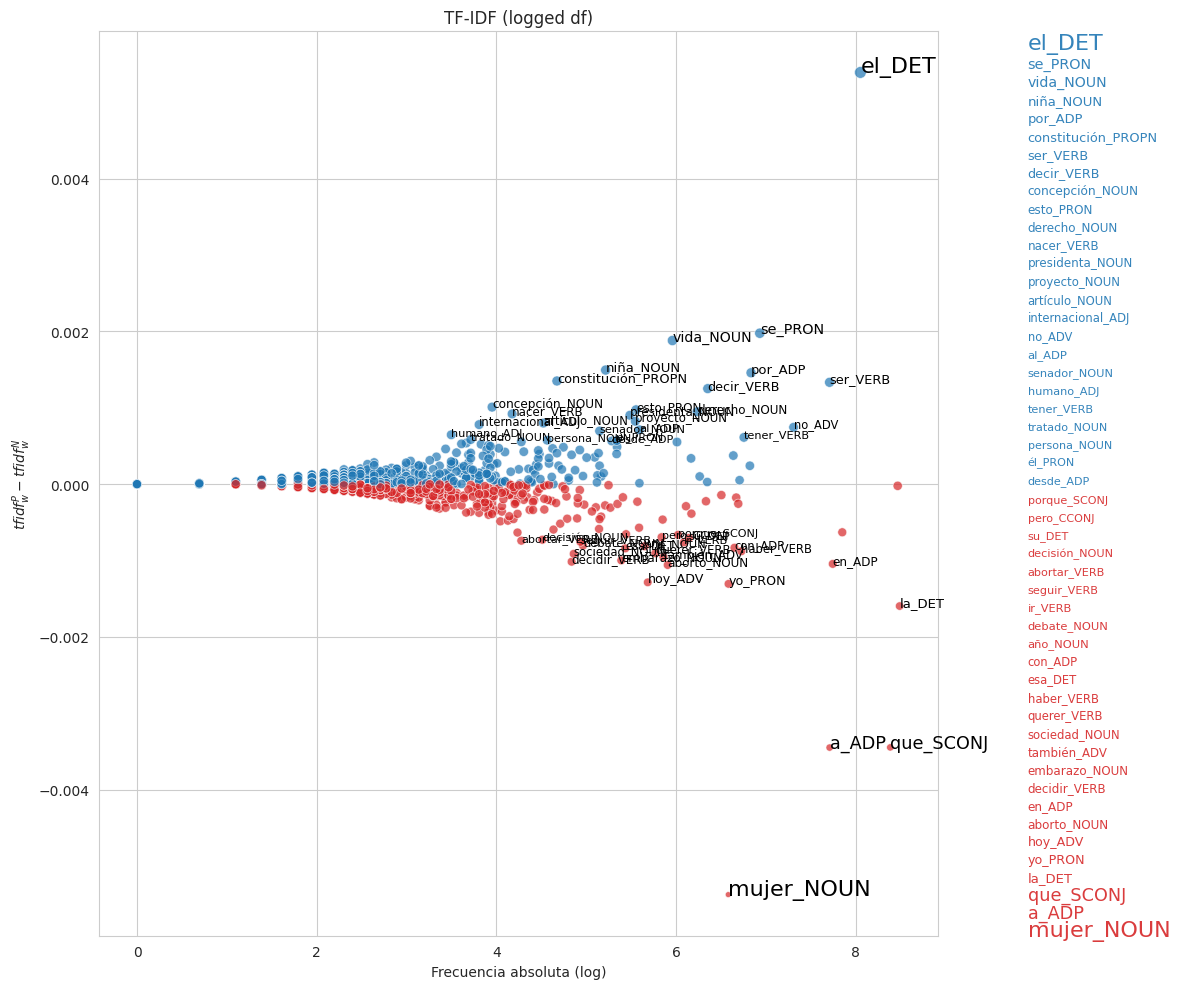

In [71]:
filename = "tfidf_dflogged"
save_dataframe(tfidf_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    tfidf_diff,
    "TF-IDF (logged df)",
    "$tfidf^{P}_{w}-tfidf^{N}_{w}$",
    file
)

### Frecuencia de término natural, frecuencia de documento natural, no normalizado

In [72]:
tf_idf = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
tf_idf.rename(columns={"pos":"f_pos", "neg":"f_neg"}, inplace=True)
tf_idf.head()

,word,total,f_pos,f_neg
0,a_adp,7.707512,0.027260,0.022286
1,abajo_adv,0.693147,0.000018,0.000033
2,abandonada_adj,0.000000,0.000018,0.000000
3,abandonado_adj,0.000000,0.000018,0.000000
4,abandonar_verb,0.000000,0.000000,0.000033


In [73]:
tf_idf["df"] = tf_idf.apply(lambda x: 1/2 if (0<x.f_pos and 0<x.f_neg) else 1/1, axis=1)
tf_idf.head()

,word,total,f_pos,f_neg,df
0,a_adp,7.707512,0.027260,0.022286,0.5
1,abajo_adv,0.693147,0.000018,0.000033,0.5
2,abandonada_adj,0.000000,0.000018,0.000000,1.0
3,abandonado_adj,0.000000,0.000018,0.000000,1.0
4,abandonar_verb,0.000000,0.000000,0.000033,1.0


In [74]:
tfidf_diff = (
    pd
    .DataFrame({
        "word": tf_idf["word"],
        "pos": tf_idf.apply(lambda x: x.f_pos/x.df, axis=1),
        "neg": tf_idf.apply(lambda x: x.f_neg/x.df, axis=1)
    })
    .assign(diff=lambda x: x.pos - x.neg)
    .merge(count_diff[["word", "total"]], on="word")
)
tfidf_diff.head()

,word,pos,neg,diff,total
0,a_adp,0.054520,0.044571,0.009949,7.707512
1,abajo_adv,0.000035,0.000066,-0.000030,0.693147
2,abandonada_adj,0.000018,0.000000,0.000018,0.000000
3,abandonado_adj,0.000018,0.000000,0.000018,0.000000
4,abandonar_verb,0.000000,0.000033,-0.000033,0.000000


In [75]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 1.0


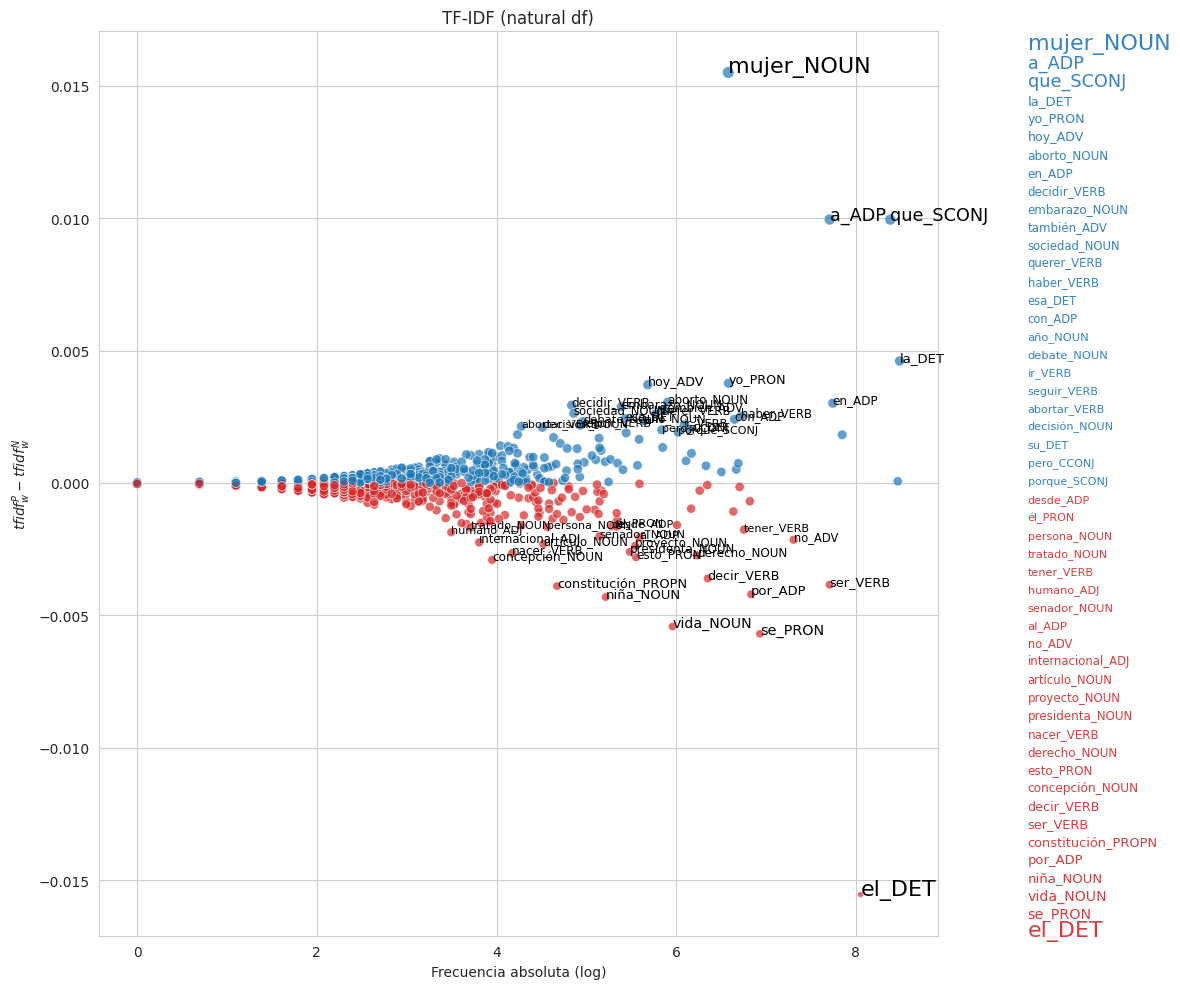

In [76]:
filename = "tfidf_dfnatural"
save_dataframe(tfidf_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    tfidf_diff,
    "TF-IDF (natural df)",
    "$tfidf^{P}_{w}-tfidf^{N}_{w}$",
    file
)

## WordScores

$$
W_{w}^{{*}^{(P-N)}} = \frac{y_{w}^{(P)}/n^{(P)}-y_{w}^{(N)}/n^{(N)}}{y_{w}^{(P)}/n^{(P)}+y_{w}^{(N)}/n^{(N)}}n_{w}
$$

In [77]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0)

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw,
        "wnkw": wkw*nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

,word,total,diff,wkw,nkw,wnkw
0,a_adp,7.707512,223.389762,0.10040,2225,223.389762
1,abajo_adv,0.693147,-0.602081,-0.30104,2,-0.602081
2,abandonada_adj,0.000000,1.000000,1.00000,1,1.000000
3,abandonado_adj,0.000000,1.000000,1.00000,1,1.000000
4,abandonar_verb,0.000000,-1.000000,-1.00000,1,-1.000000


In [78]:
corr_prop = wkw_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 0.99


In [79]:
filename = "wordscores"
save_dataframe(wkw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    wkw_diff,
    "WordScores",
    "$W^{*(P-N)}_{w}$",
    file
)

KeyError: 'pos'

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando